In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.optimize import minimize

### Importing our data of Taxi services

In [3]:
precip = pd.read_csv("uber_data _2.csv")
precip

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,3/10/2016 7:49,3/10/2016 7:50,1,0.00,-73.937164,40.764675,1,N,-73.937325,40.764629,2,1.0,0.0,0.5,0.00,0.00,0.3,1.80
1,2,3/10/2016 10:33,3/10/2016 10:35,1,0.00,-73.937050,40.764736,1,N,-73.937119,40.764732,2,1.1,0.0,0.5,0.00,0.00,0.3,1.90
2,2,3/10/2016 9:59,3/10/2016 9:59,2,0.00,0.000000,0.000000,1,N,0.000000,0.000000,2,1.5,0.0,0.5,0.00,0.00,0.3,2.30
3,2,3/10/2016 10:05,3/10/2016 10:06,2,0.00,0.000000,0.000000,1,N,0.000000,0.000000,2,1.5,0.0,0.5,0.00,0.00,0.3,2.30
4,2,3/10/2016 10:29,3/10/2016 10:29,2,0.00,0.000000,0.000000,1,N,0.000000,0.000000,2,1.5,0.0,0.5,0.00,0.00,0.3,2.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99874,2,3/10/2016 8:06,3/10/2016 9:05,1,40.27,-74.005272,40.744930,5,N,-74.484047,40.520203,1,171.0,0.0,0.5,20.00,17.00,0.3,208.80
99875,2,3/10/2016 8:18,3/10/2016 9:04,1,35.94,-73.996880,40.754520,5,N,-74.249321,40.431301,1,175.0,0.0,0.0,39.96,24.50,0.3,239.76
99876,2,3/10/2016 8:57,3/10/2016 8:57,2,0.00,-74.406517,40.859928,5,N,-74.406517,40.859928,1,180.0,0.0,0.0,45.08,0.00,0.3,225.38
99877,2,3/10/2016 12:11,3/10/2016 12:48,2,31.68,-73.875732,40.771332,5,N,-73.542061,41.049400,1,195.0,0.0,0.5,41.02,9.29,0.3,246.11


## Keeping only required columns 

In [5]:
df = precip[["tpep_dropoff_datetime","passenger_count","trip_distance", "fare_amount","tip_amount", "tolls_amount", "total_amount"]]
df

,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount
0,3/10/2016 7:50,1,0.00,1.0,0.00,0.00,1.80
1,3/10/2016 10:35,1,0.00,1.1,0.00,0.00,1.90
2,3/10/2016 9:59,2,0.00,1.5,0.00,0.00,2.30
3,3/10/2016 10:06,2,0.00,1.5,0.00,0.00,2.30
4,3/10/2016 10:29,2,0.00,1.5,0.00,0.00,2.30
...,...,...,...,...,...,...,...
99874,3/10/2016 9:05,1,40.27,171.0,20.00,17.00,208.80
99875,3/10/2016 9:04,1,35.94,175.0,39.96,24.50,239.76
99876,3/10/2016 8:57,2,0.00,180.0,45.08,0.00,225.38
99877,3/10/2016 12:48,2,31.68,195.0,41.02,9.29,246.11


### Taking Mean & Variance of Column Total Amount, We won't be able to work with Tip_amount and fare_amount because it contains zero and if we take log of zero it would be infinte

In [7]:
Total_amount_mean = df[['total_amount']].mean()
Total_amount_mean

total_amount    16.372402
dtype: float64

In [9]:
Total_amount_var = df[['total_amount']].var()
Total_amount_var

total_amount    192.905338
dtype: float64

### Implementing dlgamma & dl2gamma function for Maximum Likelihood estimation

In [10]:
from scipy.optimize import newton
from scipy.special import psi, polygamma

# Note that log_mean and mean_log are parameters of the dlgamma function
dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

In [11]:
df_Total_amount =  pd.DataFrame(df['total_amount'])

In [13]:
log_mean = Total_amount_mean.apply(np.log)
mean_log = df_Total_amount.apply(np.log).mean()

### Finding Alpha_MLE and Beta_MLE

In [14]:
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean[-1], mean_log[-1]))
alpha_mle

2.3931293170473205

In [15]:
beta_mle = alpha_mle/df['total_amount'].mean()
beta_mle

0.14616849590219022

### Making a model to compare the difference between Method of Moments & Maximum Likelihood

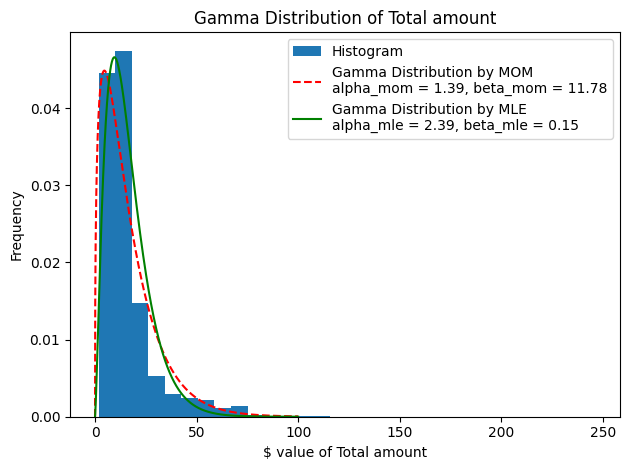

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma

# Sample data (replace this with your actual data)
data = df.total_amount

# Estimate alpha and beta from your data
alpha_mom = (data.mean() ** 2) / data.var()
beta_mom = data.var() / data.mean()
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean[-1], mean_log[-1]))
beta_mle = alpha_mle / data.mean()

# Create a histogram of the data
plt.hist(data, density=True, bins=30, label='Histogram')

# Define the range for the x-axis
x = np.linspace(0, 100, 1000)

# Plot the gamma distribution using the estimated alpha and beta
plt.plot(x, gamma.pdf(x, a=alpha_mom, scale=beta_mom), 'r--', label=f'Gamma Distribution by MOM\nalpha_mom = {alpha_mom:.2f}, beta_mom = {beta_mom:.2f}')
plt.plot(x, gamma.pdf(x, a=alpha_mle, scale=1/beta_mle), 'g', label=f'Gamma Distribution by MLE\nalpha_mle = {alpha_mle:.2f}, beta_mle = {beta_mle:.2f}')

plt.xlabel('$ value of Total amount')
plt.ylabel('Frequency')
plt.title('Gamma Distribution of Total amount')
plt.legend()
plt.tight_layout()
plt.show()

### Here we see that MLE is much more appropriately capturing the histogram and giving us a better model